{42}
None
None


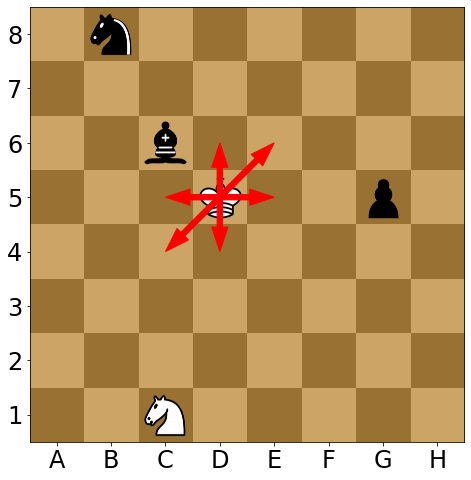

In [1]:
from ChessCore import *

game = ChessGame('1n6/8/2b5/3K2p1/8/8/8/2Q5 w - - 0 1')
moves = game.generate_all_moves()
game.plot(moves=moves)